## Load data

In [25]:
!pip install open3d

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.8 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [27]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import scipy as sp
import json
import open3d as o3d

In [11]:
def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
  ax[1].imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))

# Perfect stereo-pair
Cameras' matrices and distance between them are known

In [12]:
im1 = cv2.imread("frame_L.png")
im2 = cv2.imread("frame_R.png")

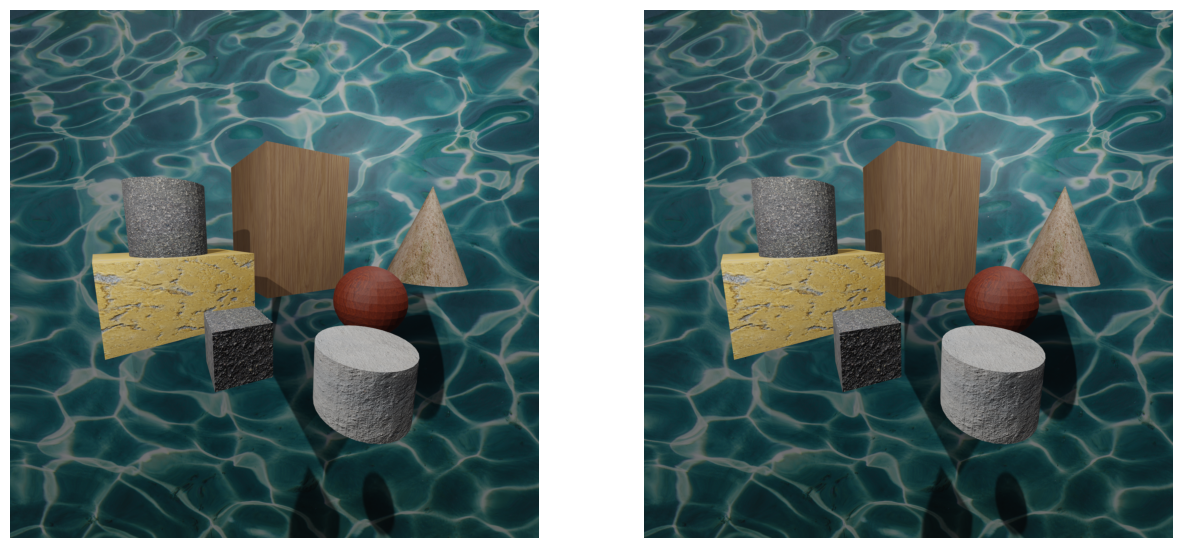

In [13]:
plot_imgs(im1, im2)

In [14]:
image_info = json.load(open("meta_info.txt"))

In [15]:
# camera matrix
K = np.array(image_info["cam"]["intrinsics"])
K

array([[711.11111111,   0.        , 800.        ],
       [  0.        , 711.11111111, 800.        ],
       [  0.        ,   0.        ,   1.        ]])

In [16]:
# rotation matrix of R camera relative to L: x_L = R * x_R
R = np.array(image_info["cams_transform"]["rotation_matrix"])
R

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [-0.,  0.,  1.]])

In [17]:
# translation vector between cameras x_L = R * x_R + t
t = np.array(image_info["cams_transform"]["translation"])
t

array([0.1, 0. , 0. ])

In [18]:
# World position of the cameras
R_l = np.array(image_info["world"]["R_l"])
R_r = np.array(image_info["world"]["R_r"])
X_l = np.array(image_info["world"]["X_l"])
X_r = np.array(image_info["world"]["X_r"])

## Triangulate key points (sparse reconstruction)

In [19]:
def match_points (gr_left, gr_right, show=False):
  corners = cv2.goodFeaturesToTrack (gr_left,
  maxCorners=2000, qualityLevel=0.5,
  minDistance=10, blockSize=15)
  pts_left = corners[:,0,:].astype (np.float32)
  pts_right = pts_left.copy()
  pts_right, status, err = cv2.calcOpticalFlowPyrLK(
  gr_left, gr_right, pts_left, pts_right, maxLevel=10)
  status = status[:, 0] > 0
  pts_left = pts_left[status]
  pts_right = pts_right[status]
  return pts_left, pts_right

In [20]:
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
pts_L, pts_R = match_points(im1_gray, im2_gray)

In [21]:
cams_R = [R_l, R_r]
cams_X = [X_l, X_r]

In [22]:
# build projection matrices P = K [R|t]
# because of the covention used x_w = Rwc*x_c + t_wc:  R = Rwc.T t = - Rwc.T*t_wc
cams_P = []
for R, X in zip(cams_R, cams_X):
  Rt = np.hstack([R.T, -(R.T @ X).reshape(-1,1)]) # [R.T|-R.T*t]
  P = np.matmul(K,Rt)
  cams_P.append(P)

In [23]:
obj_pts = cv2.triangulatePoints(cams_P[0], cams_P[1], pts_L.T, pts_R.T)
obj_pts /= obj_pts[3] # to heterogenious coordinates
im1_rgb = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
obj_cols = im1_rgb[pts_L.T[1].astype(int), pts_R.T[0].astype(int), :]


In [28]:
# Pass points to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(obj_pts[:3].T)
pcd.colors = o3d.utility.Vector3dVector(obj_cols/255.)
o3d.io.write_point_cloud("sparse_cloud.ply", pcd, write_ascii = True)

True

Draw key points

In [29]:
img_ = im1.copy()
for left_p in pts_L:
  img_ = cv2.circle(img_, left_p.astype(int), 5, (0,0,255), 5)

In [30]:
plt.figure(figsize = (16,32))
plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))

Output hidden; open in https://colab.research.google.com to view.

In [31]:
o3d.visualization.draw_plotly([pcd])

## Block matching algorithm to find disparity map
There are also some NN solutions for this kind of task.

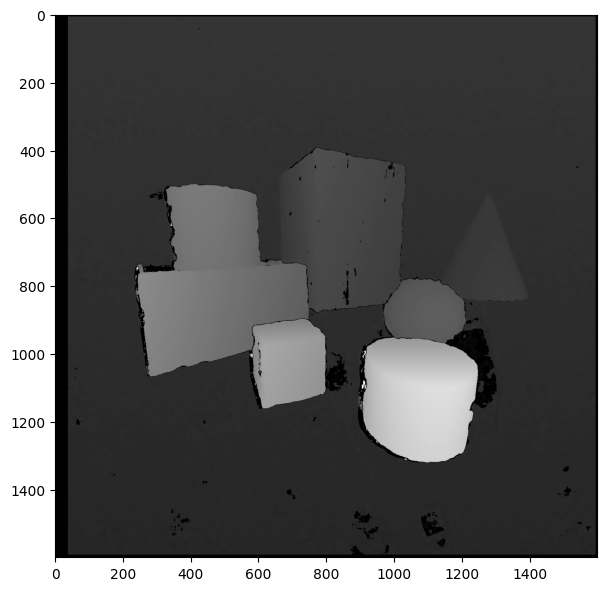

In [ ]:
stereo = cv2.StereoBM.create(numDisparities=32, blockSize=15)
disparity = stereo.compute(im1_gray,im2_gray).astype(np.float32) / 16.0
plt.figure(figsize=(7, 10))
plt.imshow(disparity,'gray')
plt.show()

In [ ]:
disparity = np.where(disparity > 0.0, disparity, 0.0) # disparity can onyl be positive

## Depth Map
Objects on the scene placed in the range between 2 and 12 meters away from camera.

In [ ]:
# Depth map
threshhold = 6.0 # threshhold to separate the background
depth = t[0] * K[0,0] / disparity[disparity> threshhold]

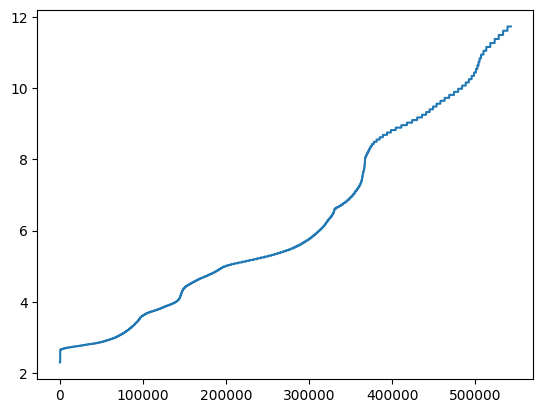

In [ ]:
plt.plot(np.sort(depth.flatten()))

## Point cloud (Dense)

In [ ]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [ ]:
# Perspective matrix (for visualization purposes we additionally rotate around x axis of left camera, so the y axis looks up)
Cx = K[0,2]
Cy = K[1, 2]
f = K[0,0]
Q = np.float32([[1, 0, 0, -Cx],
                [0,-1, 0,  Cy], # turn points 180 deg around x-axis,
                [0, 0, 0,  -f], # so that y-axis looks up
                [0, 0, 1,   0]])

In [ ]:
# Point coordinates and their colors
points = cv2.reprojectImageTo3D(disparity, Q) * t[0]
colors = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

Using Open3D

In [ ]:
!pip install open3d

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 52.9 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import open3d as o3d

In [ ]:
mask = disparity > threshhold # exlude the background
out_points = points[mask]
out_colors = colors[mask]

In [ ]:
# Pass points to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(out_points.reshape(-1,3))
pcd.colors = o3d.utility.Vector3dVector(out_colors.reshape(-1,3)/255.)
o3d.io.write_point_cloud("sync.ply", pcd)

True

In [ ]:
o3d.visualization.draw_plotly([pcd], point_sample_factor = 0.1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
 write_ply("point_cloud.ply", out_points, out_colors)

# Oblique stereo-pair
Requires stereo rectification, cameras' matrices are known (i.e. cameras are stereo calibrated)

In [ ]:
im1 = cv2.imread("frame_L.png")
im2 = cv2.imread("frame_R.png")

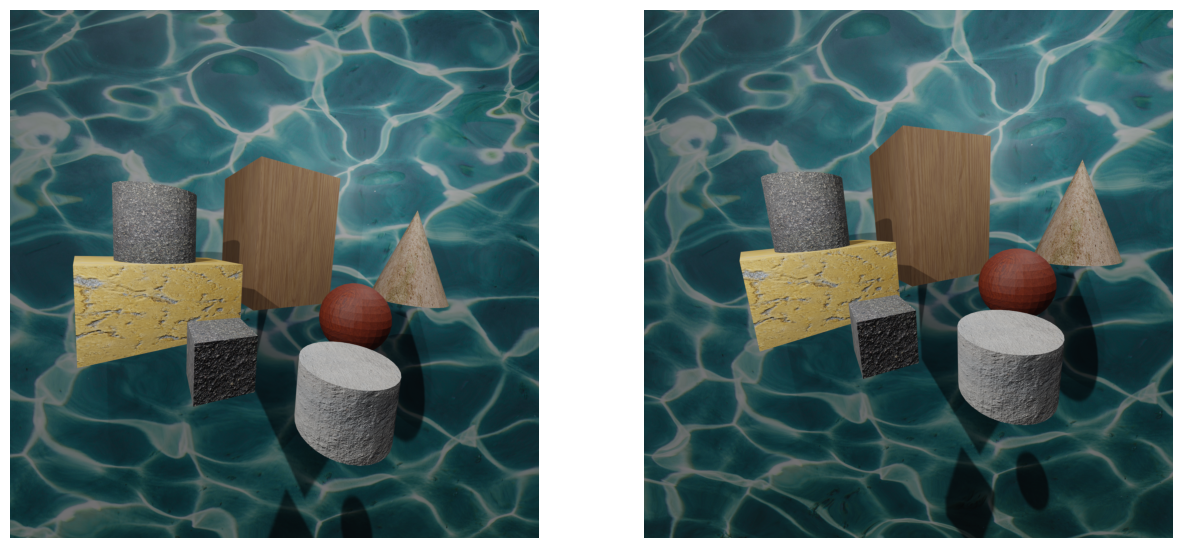

In [ ]:
plot_imgs(im1, im2)

In [ ]:
image_info = json.load(open("meta_info.txt"))

In [ ]:
image_info.keys()

dict_keys(['cam_stereo_calib', 'corruption_matrices', 'perfect_position'])

In [ ]:
# camera matrix
K = np.array(image_info["cam_stereo_calib"]["intrinsics"])
K

array([[711.11111111,   0.        , 800.        ],
       [  0.        , 711.11111111, 800.        ],
       [  0.        ,   0.        ,   1.        ]])

In [ ]:
# position of the right camera relative to the left: x_L = R_lr * x_R + t_lr
R_lr = np.array(image_info["cam_stereo_calib"]["R"])
t_lr = np.array(image_info["cam_stereo_calib"]["t"])

In [ ]:
# extrinsics for the left and right camers (world to camera transform)
R_wc_L = np.array(image_info["cam_stereo_calib"]["R_L"])
R_wc_R = np.array(image_info["cam_stereo_calib"]["R_R"])

In [ ]:
# corruption matrices wich made the perefect stereo-pair oblique x_R = dR_R @ x_R_corrupted
dR_L = np.array(image_info["corruption_matrices"]["dR_L"])
dR_R = np.array(image_info["corruption_matrices"]["dR_R"])

In [ ]:
# perfect stereo-pair position befor applying corruption matrices
R_0L = np.array(image_info["perfect_position"]["R_0L"])
R_0R = np.array(image_info["perfect_position"]["R_0R"])

In [ ]:
assert(np.allclose(R_wc_L @ dR_L.T - R_0L + 1, 1.)), "corruption matrix dR is inconsistent with inital R0 and corrupted position R1"
assert(np.allclose(R_wc_R @ dR_R.T - R_0R + 1, 1.)), "corruption matrix dR is inconsistent with inital R0 and corrupted position R1"

In [ ]:
assert(np.allclose(dR_L @ R_lr @ dR_R.T - np.eye(3) + 1, 1.)), "R_LR must be identity after undoing the corruption dR_L, dr_R"
assert(np.allclose(dR_L @ t_lr - np.array([np.linalg.norm(t_lr), 0, 0]) + 1, 1.)), "after undoing corruption dR_L -  t_lr must have only x- component"

## Fundamental matrix

Feature matching

In [ ]:
def match_points (gr_left, gr_right, show=False):
  corners = cv2.goodFeaturesToTrack (gr_left,
  maxCorners=2000, qualityLevel=0.5,
  minDistance=10, blockSize=15)
  pts_left = corners[:,0,:].astype (np.float32)
  pts_right = pts_left.copy()
  pts_right, status, err = cv2.calcOpticalFlowPyrLK(
  gr_left, gr_right, pts_left, pts_right, maxLevel=10)
  status = status[:, 0] > 0
  pts_left = pts_left[status]
  pts_right = pts_right[status]
  return pts_left, pts_right

In [ ]:
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
pts_L, pts_R = match_points(im1_gray, im2_gray)

In [ ]:
imgs_merged = cv2.cvtColor(np.concatenate((im1, im2), axis = 1),cv2.COLOR_BGR2RGB)
for _ in range(20):
  i = np.random.randint(0,len(pts_L))
  start_p = tuple(pts_L[i].astype(int))
  end_p = (int(pts_R[i][0]) + im2.shape[1], int(pts_R[i][1]))
  imgs_merged = cv2.line(imgs_merged, start_p, end_p, (0, 255, 0), 2)

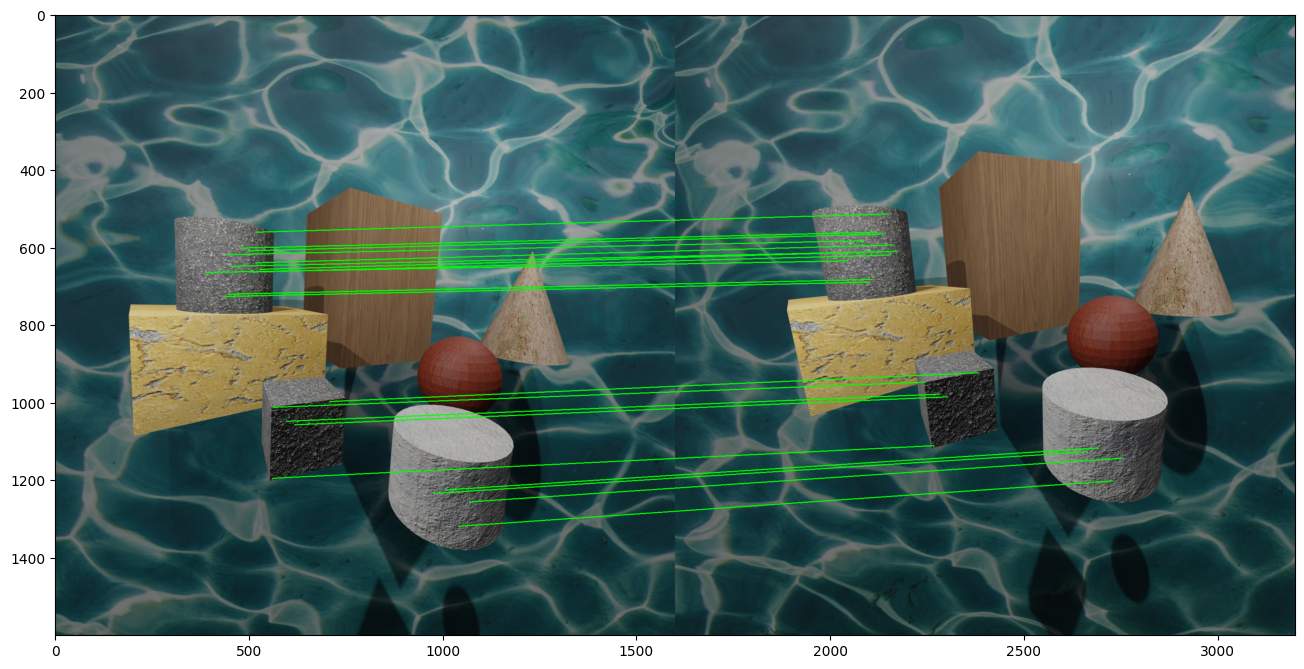

In [ ]:
plt.figure(figsize = (16,32))
plt.imshow(imgs_merged)

Fundamental matrix projects point from one image plane  to the corresponding epipolar line on the other $u_L^TFu_R^T = 0$, where $u = [u_x, u_y, 1]^T$

In [ ]:
F, _  = cv2.findFundamentalMat(pts_R, pts_L, cv2.FM_RANSAC, 0.5, 0.8, 2000) # the order of arguments pts_R, pts_L correspond to the following convention for fundamental matrix: u_L.T @ F @ u_R = 0

In [ ]:
def get_line_value(line, point, x_axis = True):
  """
  Computes the value of the another line (ax + by + c = 0) point coordinate given the other
  """
  if x_axis:
    return - (line[2] + line[0]*point)/line[1]
  else:
    return - (line[2] + line[1]*point)/line[0]

def get_line_ends(line, vertices):
  """
  Finds wich of the four image boundaries are intersected by the epipolar line.
  Return pixel coordinate of the line ends to draw them using OpenCV function cv2.line()
  """
  ends = []
  for i in range(len(vertices)):
    vert1 = vertices[i]
    vert2 = vertices[(i + 1) % len(vertices)]
    t = (line.T @ np.append(vert1, 1.)) * (line.T @ np.append(vert2, 1))
    if t > 0 :
      continue
    indx = np.argmax(vert1 == vert2)
    x = vert1[indx] if indx == 0 else get_line_value(line, vert1[indx], x_axis= False)
    y = vert1[indx] if indx == 1 else get_line_value(line, vert1[indx], x_axis= True)
    ends.append((int(np.floor(x)), int(np.floor(y))))
  return ends

def draw_epipolar_lines(im_L, im_R, pts_L, pts_R, F, N_pts = 5, pts_inds = None):
  """
  This function randomly selects N_pts from the corresponding image points pts_L, pts_R
  and draws epipolar lines on both image planes im_L, im_R using epipolar constraint provided by fundamental matrix F.
  The intersection of epipolar lines is epipole (or epipolar point), which is projection of cameras' origins
  """
  im_L = im_L.copy()
  im_R = im_R.copy()
  vertices = np.array([[0, 0],
                      [im1.shape[1],0],
                      [im1.shape[1], im1.shape[0]],
                      [0, im1.shape[0]]
                      ])
  if pts_inds is None:
    inds = np.zeros((N_pts,), dtype = int)
  else:
    inds = None

  for indx in range(N_pts):
    if pts_inds is None:
      i = np.random.randint(0,len(pts_L))
      inds[indx] = i
    else:
      i = pts_inds[indx]
    left_p = pts_L[i]
    right_p = pts_R[i]

    # epipolar line on the left and right image planes
    epipolar_line_coef_L =  F @ np.append(right_p, 1.0)
    epipolar_line_coef_R =  np.append(left_p, 1.0).T @ F

    # draw corner points
    im_L = cv2.circle(im_L, left_p.astype(int), 5, (0,0,255), 5)
    im_R = cv2.circle(im_R, right_p.astype(int), 5, (0,0,255), 5)
    # draw lines
    ends_L = get_line_ends(epipolar_line_coef_L, vertices)
    ends_R = get_line_ends(epipolar_line_coef_R, vertices)
    im_L = cv2.line(im_L, ends_L[0], ends_L[1], (0, 255, 0), 2)
    im_R = cv2.line(im_R, ends_R[0], ends_R[1], (0, 255, 0), 2)
  return im_L, im_R, inds

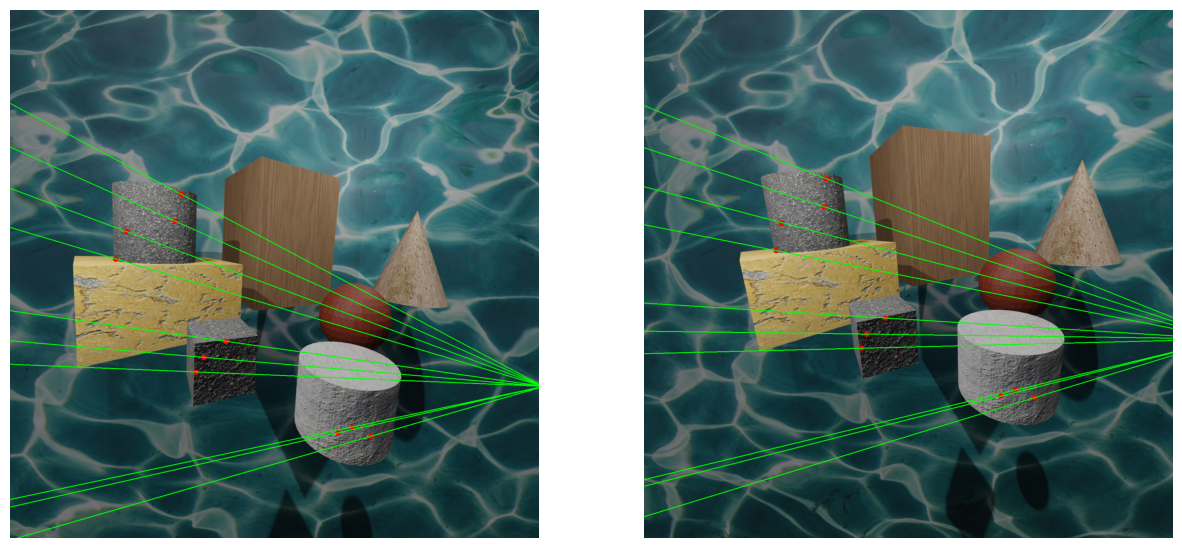

In [ ]:
im_epi_L, im_epi_R, pts_inds = draw_epipolar_lines(im1, im2, pts_L, pts_R, F, N_pts = 10)
plot_imgs(im_epi_L, im_epi_R)

## Image rectification
Transformation of both the left and right images, so they would look like as if they have been taken by perfect stereo-pair and the epipolar lines must become horisontal, which will facilitate the feature matching search and building depth map. Cameras must be stereo calibrated, i.e. K_L, K_R, R_lr, t_lr must be known

In [ ]:
dR_Re, dR_Le, PnR, PnL, Q, _, _ = cv2.stereoRectify(K, np.zeros((1,5)), K, np.zeros((1,5)), (im1.shape[1], im1.shape[0]), R_lr, t_lr)

In [ ]:
# check whether estimated corruption matrices dR_Re and dR_Le are correct
assert(np.allclose(dR_Le @ R_lr @ dR_Re.T - np.eye(3) + 1, 1.)), "R_LR must be identity after undoing the corruption dR_L, dr_R"
assert(np.allclose(dR_Le @ t_lr - np.array([np.linalg.norm(t_lr), 0, 0]) + 1, 1.)), "after undoing corruption dR_L -  t_lr must have only x- component"

Applying rectification (1st method)

In [ ]:
# construct homography matrices for both camera to transform each image to the common plane which corresponds to the prefect stereo pair
H_L = K @ dR_Le @ np.linalg.inv(K)
H_R = K @ dR_Re @ np.linalg.inv(K)

In [ ]:
im_L_rot = cv2.warpPerspective(im1, H_L, (im1.shape[1], im1.shape[0])) # im_rot ~ H_L * im1
im_R_rot = cv2.warpPerspective(im2, H_R, (im2.shape[1], im1.shape[0]))

In [ ]:
# transform key points using homographies for the right and left images
pts_L_rot = cv2.perspectiveTransform(pts_L.reshape(-1,1,2).astype(np.float32), H_L).squeeze()
pts_R_rot = corners_pts_trans_new = cv2.perspectiveTransform(pts_R.reshape(-1,1,2).astype(np.float32), H_R).squeeze()

In [ ]:
# new fundamental matrix u_L_rot * F_new * u_R_rot for rectified images
Fnew = np.zeros((3,3))
Fnew[1,2] = - np.linalg.norm(t_lr)/K[0,0]
Fnew[2,1] = - Fnew[1,2]
Fnew

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.00014063],
       [ 0.        ,  0.00014063,  0.        ]])

Epipolar lines are horisontal for rectified images, which facilitates key points matching

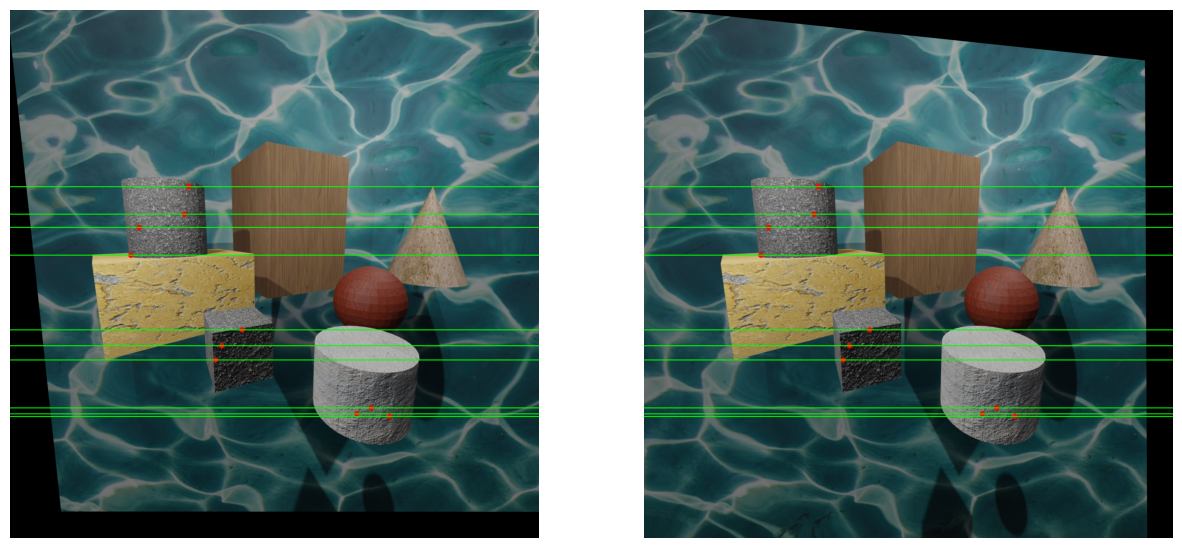

In [ ]:
im_L_rot_ep, im_R_rot_ep, _ = draw_epipolar_lines(im_L_rot, im_R_rot, pts_L_rot, pts_R_rot, Fnew, N_pts = 10, pts_inds = pts_inds)
plot_imgs(im_L_rot_ep, im_R_rot_ep)

We can translate/scale images as we want applying to H_L/H_R additional homography matrices (affine transfornms)

In [ ]:
# additional transaltions to adjust resulting images
trans_L = np.array([-80., 0.])
trans_R = np.array([80., 0.])
H_L_tr= np.eye(3)
H_L_tr[:2,2] = trans_L
H_R_tr = np.eye(3)
H_R_tr[:2,2] = trans_R

In [ ]:
H_Lnew = H_L_tr @ H_L
H_Rnew = H_R_tr @ H_R
im_L_rot_new = cv2.warpPerspective(im1, H_Lnew, (im1.shape[1], im1.shape[0]))
im_R_rot_new = cv2.warpPerspective(im2, H_Rnew, (im2.shape[1], im1.shape[0]))

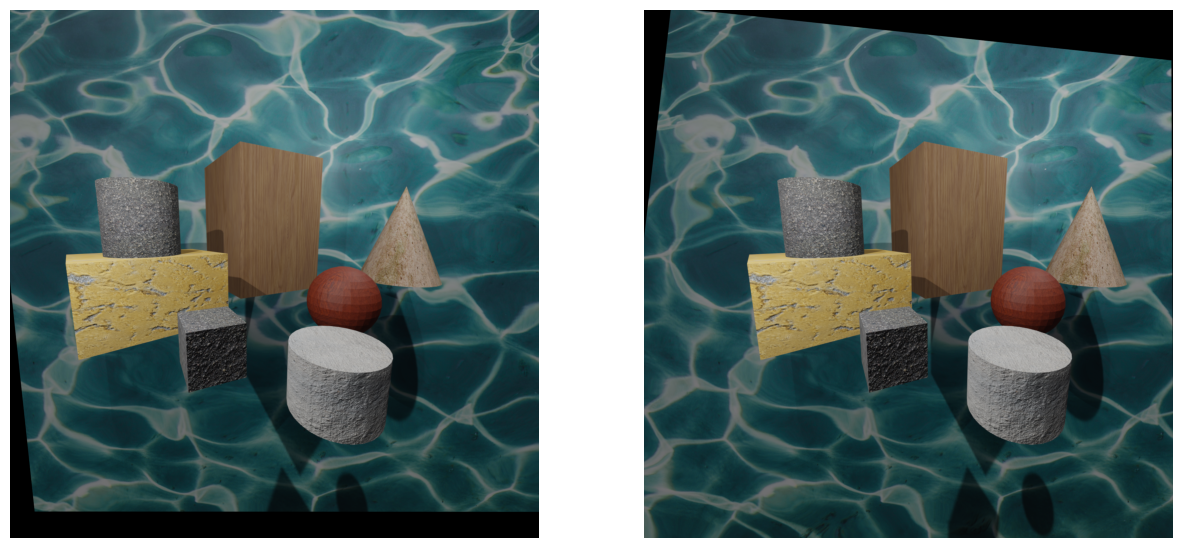

In [ ]:
plot_imgs(im_L_rot_new, im_R_rot_new)

Applying rectification (2nd method)

In [ ]:
mapL1, mapL2 = cv2.initUndistortRectifyMap(K, np.zeros((1,5)), dR_Le, PnL, (im1.shape[1], im1.shape[0]), cv2.CV_32FC1)
mapR1, mapR2 = cv2.initUndistortRectifyMap(K, np.zeros((1,5)), dR_Re, PnR, (im2.shape[1], im2.shape[0]), cv2.CV_32FC1)

For remap to work faster in real-time see: https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=remap#cv2.remap

In [ ]:
# cv2.remap(im, mapx, mapy)  im_new(x,y) = src(mapx(x,y), mapy(x,y))
imgL_rect = cv2.remap(im1, mapL1, mapL2, cv2.INTER_LINEAR)
imgR_rect = cv2.remap(im2, mapR1, mapR2, cv2.INTER_LINEAR)

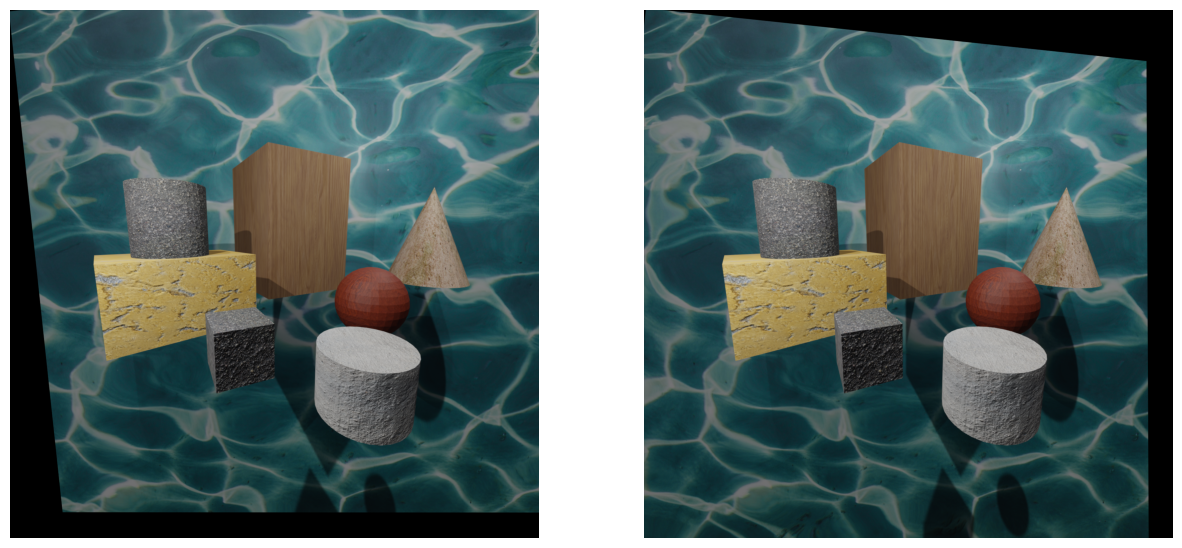

In [ ]:
plot_imgs(imgL_rect, imgR_rect)

## Disparity and Depth map for rectified iamges

In [ ]:
imL_rec_gray = cv2.cvtColor(imgL_rect, cv2.COLOR_BGR2GRAY)
imR_rec_gray = cv2.cvtColor(imgR_rect, cv2.COLOR_BGR2GRAY)

Disparity map

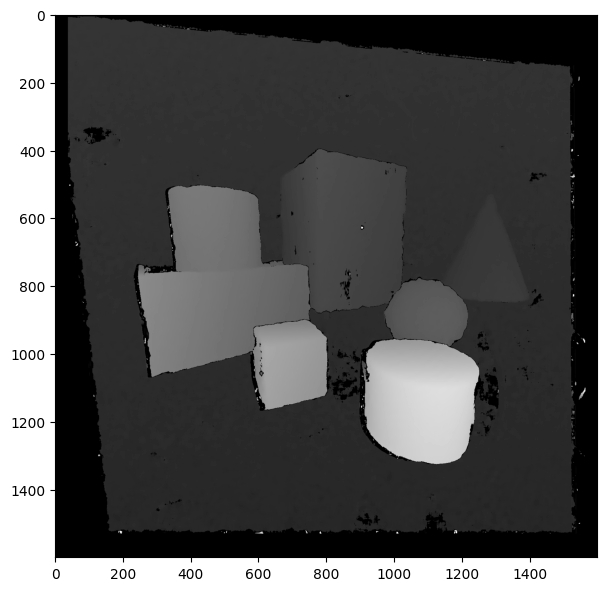

In [ ]:
stereo = cv2.StereoBM.create(numDisparities=32, blockSize=15)
disparity = stereo.compute(imL_rec_gray,imR_rec_gray).astype(np.float32) / 16.0 # it's necessary to divide by 16 to get distance between corresponding points in pixels
plt.figure(figsize=(7, 10))
plt.imshow(disparity,'gray')
plt.show()

Depth map (consistent with the depth map for tthe same scene obtained by using perfect stereo pair)

In [ ]:
disparity = np.where(disparity > 0.0, disparity, 0.0) # disparity can onyl be positive

In [ ]:
coord3D = cv2.reprojectImageTo3D(disparity, Q)

In [ ]:
coord3D.shape

(1600, 1600, 3)

inf

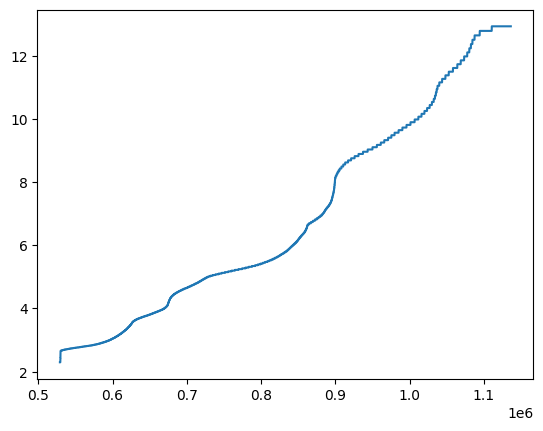

In [ ]:
# coordinates in the right camera frame
depth = -coord3D[:,:, 2].flatten() # WHY IT'S NEGATIVE?
thresh = 13 # look for everythig within 15 meters
plt.plot(np.sort(depth[depth < thresh]))

## Estimating R_lr,t_lr from Essential matrix
(Useful for visual odometry, structure from motion, multi-view 3D reconstruction or for uncalibrated stereo-pair)
We only need to know camera matrices: K_L, K_R. After estimating R_lr, t_lr from essential matrix - we can rectify images and find depth map.
We can obtaing essential matrix from fundamental as E =  $K_L^T F K_R$ or using cv2.findEssentialMat() function


Decompose essential matrix $x_L^T E x_R $ = 0
$$E = TR_{LR} $$
$$ E = U S V^T$$
Let's introduce $W = [[0, -1, 0], [1, 0, 0], [0, 0, 1]]$ \\
We have two solutions for rotation matrix
$$R_{LR} = UWV^T or R_{LR} = UW^{-1}V^T$$
And two solutions for translation vector (they are different by the sign)
$$ T = \pm USWU^T$$
or  
$$ T = \pm ER_{LR}^T$$
In total for a given essential matrix we have 4 possible solutions, we choose the correct one requiring the depth to be positive
NB: the translation vector is determined only up to a constant factor, so for comparison it's better to normalize translation vector

In [ ]:
E, inliers = cv2.findEssentialMat(pts_R, pts_L, K, cv2.FM_RANSAC, 0.5, 0.8, 2000) # x_L * E * x_R = 0

Essential matrix decomposition using SVD

In [ ]:
U, s, Vh = sp.linalg.svd(E) # last row of Vh is our homography matrix

In [ ]:
# two solutions for rotation matrix
R_lr_e1 = U @ W @ Vh
R_lr_e2 = U @ W.T @ Vh

In [ ]:
# translation vector
T_lr_e = U @ np.diag(s) @  W @ U.T
t_e =  np.array([-T_lr_e[1,2], T_lr_e[0,2], - T_lr_e[0,1]])

In [ ]:
-R_lr_e1

array([[ 0.98877662, -0.09677151, -0.11382472],
       [ 0.1071851 ,  0.99022711,  0.08922795],
       [ 0.1040776 , -0.10042682,  0.98948588]])

In [ ]:
R_lr_e2

array([[-0.7986487 , -0.59370148, -0.09838096],
       [-0.60141589,  0.79322583,  0.09535042],
       [-0.02142863, -0.13531936,  0.99057028]])

In [ ]:
R_lr # true rotation matrix

array([[ 0.98905879, -0.09878654, -0.1095624 ],
       [ 0.10969776,  0.98907375,  0.09848602],
       [ 0.0986362 , -0.10942724,  0.98908877]])

In [ ]:
t_e/np.linalg.norm(t_e)

array([0.92764044, 0.36775071, 0.0651354 ])

In [ ]:
t_lr/np.linalg.norm(t_lr) # true translation vector

array([0.99726095, 0.05499952, 0.04945356])

Essential matrix decomposition using built-in OpenCV function cv2.decomposeEssentialMat

In [ ]:
R1, R2, t = cv2.decomposeEssentialMat(E)


In [ ]:
R1

array([[ 0.7986487 ,  0.59370148,  0.09838096],
       [ 0.60141589, -0.79322583, -0.09535042],
       [ 0.02142863,  0.13531936, -0.99057028]])

In [ ]:
R2

array([[ 0.98877662, -0.09677151, -0.11382472],
       [ 0.1071851 ,  0.99022711,  0.08922795],
       [ 0.1040776 , -0.10042682,  0.98948588]])

In [ ]:
R_lr # true rotation matrix

array([[ 0.98905879, -0.09878654, -0.1095624 ],
       [ 0.10969776,  0.98907375,  0.09848602],
       [ 0.0986362 , -0.10942724,  0.98908877]])

In [ ]:
t.flatten()/np.linalg.norm(t)

array([0.92764044, 0.36775071, 0.0651354 ])

In [ ]:
t_lr/np.linalg.norm(t_lr) # true translation vector

array([0.99726095, 0.05499952, 0.04945356])

Essential matrix decomposition using built-in OpenCV function recoverPose()
It uses chirality check to choose from 4 possible solutions

In [ ]:
_, R, t, _, triang_pts = cv2.recoverPose(E, pts_L, pts_R, K, distanceThresh = 40)

In [ ]:
triang_pts.shape

(4, 152)

In [ ]:
_, R, t, _ = cv2.recoverPose(E, pts_L, pts_R, K)

In [ ]:
R

array([[ 0.98877662, -0.09677151, -0.11382472],
       [ 0.1071851 ,  0.99022711,  0.08922795],
       [ 0.1040776 , -0.10042682,  0.98948588]])

In [ ]:
R_lr # true rotation matrix

array([[ 0.98905879, -0.09878654, -0.1095624 ],
       [ 0.10969776,  0.98907375,  0.09848602],
       [ 0.0986362 , -0.10942724,  0.98908877]])

array([255], dtype=uint8)

Building projection matrices from R_lr, t_lr  and perfoming triangulation (the translation between the cameras is determined up to scale factor)

In [ ]:
P_L = np.concatenate((K, np.zeros((3,1))), axis=1) #   K [I | 0] all 3d points relative to the left camera frame
scale = 0.1 # scale for t, for our case from synthetic data we know it must be 0.1m
P_R = np.dot(K, np.concatenate((R.T,  -R.T@t*scale), axis=1))

In [ ]:
obj_pts = cv2.triangulatePoints(P_L, P_R, pts_L.T, pts_R.T)

In [ ]:
obj_pts /= obj_pts[3] # convert to heterogenous coordinates

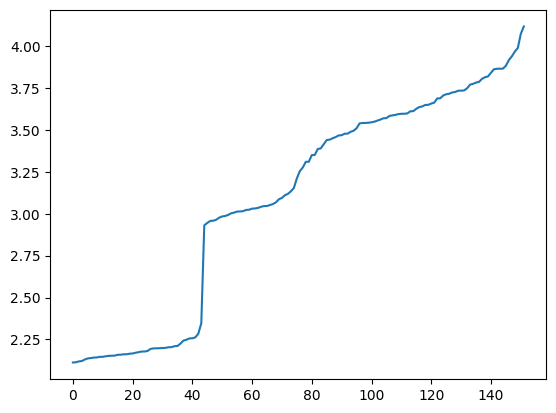

In [ ]:
plt.plot(np.sort(obj_pts[2]))